In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
tr_path = "https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv"
ts_path = "https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv"

train_df = pd.read_csv(tr_path)
test_df = pd.read_csv(ts_path)

In [5]:
scale_factor = 1000.0

train_df["median_house_value"] /= scale_factor 

test_df["median_house_value"] /= scale_factor

> ### Functions for building and training our model

In [14]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.linear = nn.Linear(in_features=1, out_features=1)

    def forward(self, x):
        return self.linear(x)
    
def build_model(my_learning_rate):
    model = LinearRegression()
    loss_fn = nn.MSELoss()
    
    optimizer = optim.RMSprop(model.parameters(), lr=my_learning_rate)
    return model, loss_fn, optimizer

def train_model(model, df, loss_fn, optimizer, feature, label, epochs,
                batch_size, validation_split=0.2):
    train_loss_values = []
    val_loss_values = []
    
    feature_tensor = torch.tensor(df[feature].values,
                                  dtype=torch.float32).unsqueeze(dim=1)
    
    label_tensor = torch.tensor(df[label].values,
                                dtype=torch.float32).unsqueeze(dim=1)
    
    dataset = torch.utils.data.TensorDataset(feature_tensor, label_tensor)
    
    total_samples = len(df)
    train_size = int((1 - validation_split) * total_samples)
    val_size = total_samples - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(dataset,
                                                               [train_size, val_size])
    
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size, shuffle=True)
    
    val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                                 batch_size=batch_size, shuffle=False)
    
    for epoch in range(epochs):
        model.train()
        tr_epoch_loss = 0.0
        for batch_feature, batch_label in train_dataloader:
            train_preds = model(batch_feature)
            train_loss = loss_fn(train_preds, batch_label)
            tr_epoch_loss += train_loss.item()
            optimizer.zero_grad()   
            train_loss.backward()   
            optimizer.step()
        train_loss_values.append(tr_epoch_loss / len(train_dataloader))
        
        model.eval()
        with torch.no_grad():
            val_epoch_loss = 0.0
            for batch_feature, batch_label in val_dataloader:
                val_preds = model(batch_feature)
                val_loss  = loss_fn(val_preds, batch_label)
                val_epoch_loss += val_loss.item()
        val_loss_values.append(val_epoch_loss / len(val_dataloader))
        
        print(f"Epoch: {epoch} | Train Loss: {tr_epoch_loss / len(train_dataloader)} | Validation Loss: {val_epoch_loss / len(val_dataloader)}")
    
    trained_weight = model.linear.weight.item()
    trained_bias = model.linear.bias.item()
    
    return trained_weight, trained_bias, train_loss_values, val_loss_values

> #### Plotting functions

In [19]:
def plot_the_loss_curve(epochs, tr_error, val_error):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")
    tr_error = np.sqrt(tr_error)
    val_error = np.sqrt(val_error)
    plt.plot(epochs, tr_error, label="Training Loss")
    plt.plot(epochs, val_error, label="Validation Loss")
    plt.legend()
    plt.show()

+ In the code below, the `validation_split` variable specifies the proportion of the original training set that will serve as the validation set<br><br>
+ The original training set contains 17,000 examples. Therefore, a validation_split of 0.2 means that:
    + 17,000 * 0.2 ~= 3,400 examples will become the validation set
    + 17,000 * 0.8 ~= 13,600 examples will become the new training set
<br><br>
+ If the data in the training set is similar to the data in the validation set, then the two loss curves and the final loss values should be almost identical<br><br>
+ However, we see that the loss curves and final loss values are not almost identical. Hmm, that's odd<br><br><br><br>

+ Let's experiment with two or three different values of `validation_split` and see if it fixes the problem?<br><br>

In [12]:
learning_rate = 0.08
epochs = 30
batch_size = 100

validation_split = 0.2

my_feature = "median_income"
my_label = "median_house_value"

In [15]:
model, loss_fn, optimizer = build_model(learning_rate)

tr_weight, tr_bias, tr_loss_list, val_loss_list = train_model(model, train_df, loss_fn,
                                                              optimizer, my_feature,
                                                              my_label, epochs,
                                                              batch_size)

Epoch: 0 | Train Loss: 34845.17820829504 | Validation Loss: 23404.916877297794
Epoch: 1 | Train Loss: 18474.782298368566 | Validation Loss: 13461.652774586397
Epoch: 2 | Train Loss: 11184.2056202608 | Validation Loss: 8708.859906364889
Epoch: 3 | Train Loss: 8029.799664665671 | Validation Loss: 7050.88045726103
Epoch: 4 | Train Loss: 7165.723442526425 | Validation Loss: 6796.624526079963
Epoch: 5 | Train Loss: 7072.329431870405 | Validation Loss: 6789.649055032169
Epoch: 6 | Train Loss: 7071.114939970129 | Validation Loss: 6790.186552159927
Epoch: 7 | Train Loss: 7070.079288258272 | Validation Loss: 6790.273279526655
Epoch: 8 | Train Loss: 7070.4416719324445 | Validation Loss: 6795.123894186581
Epoch: 9 | Train Loss: 7070.801326976103 | Validation Loss: 6793.196877872243
Epoch: 10 | Train Loss: 7070.103865679573 | Validation Loss: 6789.175422219669
Epoch: 11 | Train Loss: 7069.551176183364 | Validation Loss: 6789.732120289522
Epoch: 12 | Train Loss: 7071.32134291705 | Validation Loss: 

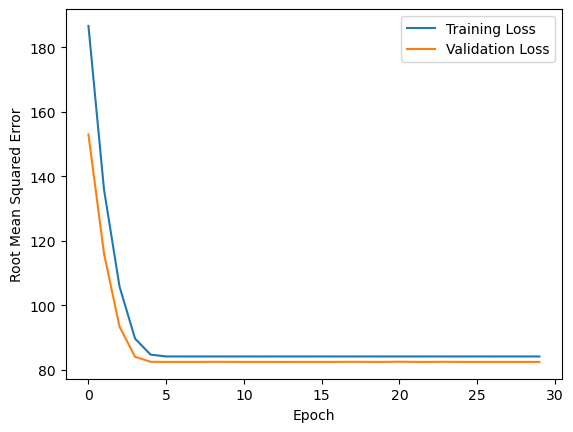

In [20]:
plot_the_loss_curve(range(epochs), np.array(tr_loss_list), np.array(val_loss_list))